In [2]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

In [3]:
def pam_symbol_error_rate(M, Iavg, noise):
    const = (M-1)/M
    x = Iavg / ((M-1)*noise * np.sqrt(2))
    return const * erfc(x)

def pam_bit_error_rate(M, Iavg, noise):
    return pam_symbol_error_rate(M, Iavg, noise) / np.log2(M)

def nrz_bit_error_rate(OMA_current, noise):

    Q = OMA_current / (noise) ##Iavg = OMA, noise in noise amplitude
    #F is the booster amplifier noise figure in linear units
    
    return 0.5 * erfc(Q/(np.sqrt(2)))

def max_current(power):
    responsivity = 0.9  # resposivity in A/W
    return responsivity * power

# def avg_current(power):
#     return max_current(power) / 2  # 3 dB penalty because of PAM modulation

def calculate_noise(B_e, B_o, signal_power, ase_power, G, F):
    
    temp = 300  # temperature in K
    noise_fig = 3  # noise figure of amplifier stage in dB, ideal
    resistance = 2000  # in Ohm
    RIN = -148  # dB/Hz

    # constants
    kB = 1.380649e-23  # Boltzmann constant, J/K
    q = 1.60217662e-19  # electronic charge, C
    h = 6.626e-34
    wavelength = 1310e-9
    c = 3e8
    photon_energy = h*c/wavelength


    ##### ASE_POWER WILL ALSO EFFECT OUR "0" (which is subtracted in OMA). CHECK
    ase_power = ase_power + G*F*photon_energy*B_o
    I_signal = max_current(G*signal_power)
    I_ase = max_current(ase_power)  #this is outgoing ASE power
    
    abs_noise_fig = np.power(10, noise_fig / 10)
    abs_rin = np.power(10, RIN/10)

    # Calculate the individual noise**2
    thermal_noise = 4 * kB * temp * abs_noise_fig * B_e / resistance *I_signal/I_signal
    shot_noise = 2 * q * I_signal * B_e
    laser_noise = abs_rin * I_signal**2 * B_e
    
    if F == 1:
            G=1
            ase_power = ase_power + G*F*photon_energy*B_o
            I_ase = max_current(ase_power)  #this is outgoing ASE power
        
            ase_shot_noise = 0*(I_signal/I_signal)
            s_sp_noise = 0*(I_signal/I_signal)
            sp_sp_noise = 0*(I_signal/I_signal)
    else:
        ase_shot_noise = 2 * q * I_signal * B_e
        #rin_sp_noise = abs_rin*I_signal*I_ase*(B_e/B_o)
        s_sp_noise = 2*I_signal*I_ase*B_e/B_o
        sp_sp_noise = I_ase**2*(B_e/B_o)*(I_signal/I_signal)

    noise = thermal_noise + shot_noise + laser_noise + ase_shot_noise+s_sp_noise+sp_sp_noise
    noise_values= {'thermal': np.sqrt(thermal_noise),
                   'shot': np.sqrt(shot_noise),
                   'rin': np.sqrt(laser_noise),
                   'ase_shot': np.sqrt(ase_shot_noise),
                   's_sp': np.sqrt(s_sp_noise),
                   'sp_sp': np.sqrt(sp_sp_noise),
                   'total': np.sqrt(noise),
                   'ase_power': ase_power,
                }
    
    return noise_values  # amplitude, not power



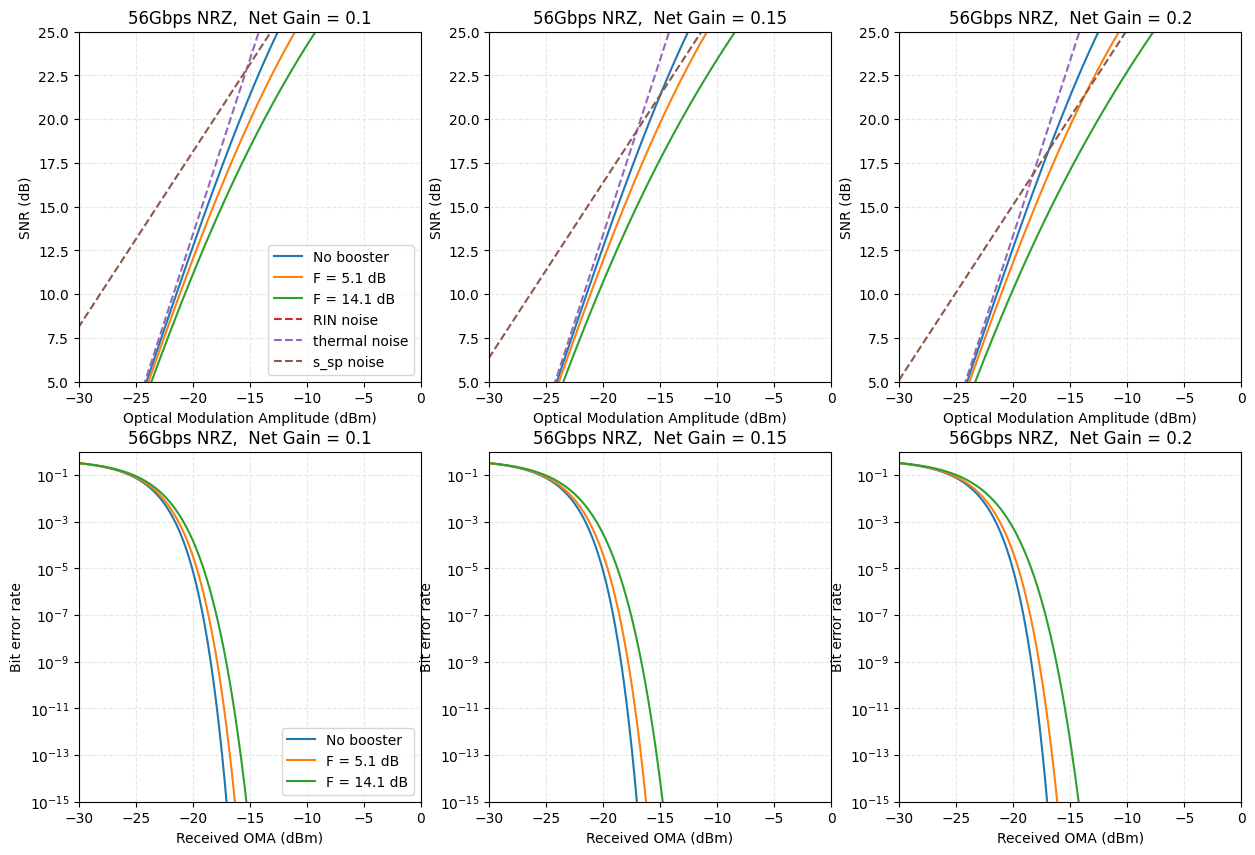

F=1 corresponds to no booster amplifier
RIN limited at SNR = 24dB
SNR = Q^2 = (I_1-I_0)^2/(n1+n0)^2
This definition of SNR is more closely aligned. SNR = (I1/n1)^2 is not applicable since that only applies when I0&n0 are negligible


In [6]:
#This is actually a sweep of the OMA
OMA_power_dBm = np.linspace(-40, 10, 1001)
OMA_power = 1e-3 * np.power(10, OMA_power_dBm/10, dtype=np.float64)

bandwidth = np.array([56]) # in GHz 56Gb/s corresponds to ~80Ghz approximate BW [Ghz] = 1.3*[Gb/s]
#convert Gb/s to Ghz --> Sync function
error_rate = []

lp1 = OMA_power*1.47 #These values roughly approximated from eye diagram for logical 1/0
lp0 = OMA_power*0.444

bw_e = 56
bw_o = 126

#Losses = Laser in Fiber to PD (not including ~0.9A/W in PD, accounted for in calculate_noise)
loss_link_dB = 25
loss_link = 10**(loss_link_dB/10)

loss_MUX_dB = 8
loss_MUX = 10**(loss_MUX_dB/10)
#gain = [-8.5, - 10.3]

loss_total = loss_link*loss_MUX
gain =[0.1, .15, .2]
noise_figure = [1,3.2, 8*3.2]

#plt.figure(figsize=(30, 10))
fig, axes = plt.subplots(2, len(gain), figsize = (15,10))
for indexG, G in enumerate(gain):
    for indexF, F in enumerate(noise_figure):
    
        if F==1:
            n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, 1, F) #At large values of F and G, the OMA can reduce - this is not taken into account
            n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, 1, F)
            rOMA_power_dBm = 10*np.log10(1*OMA_power/1e-3)
            rOMA_current = max_current(1*OMA_power)
            ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total'])
        else:
            n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, G, F)
            n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, G, F)
            rOMA_power_dBm = 10*np.log10(G*OMA_power/1e-3)
            rOMA_current = max_current(G*OMA_power)
            ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total'])

        snr = 10*np.log10(rOMA_current**2/((n1['total']+n2['total'])**2))

        if F == 1:
            Flabel = "No booster"
        else:
            Flabel = f"F = {round(10*np.log10(F), 1)} dB"
        axes[0, indexG].plot(rOMA_power_dBm, snr, label=Flabel)
        axes[1, indexG].semilogy(rOMA_power_dBm, ber, label=Flabel)
    
    axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['rin']+n2['rin'])**2)), linestyle = 'dashed', label="RIN noise")
    axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['thermal']+n2['thermal'])**2)), linestyle = 'dashed', label="thermal noise")
    axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['s_sp']+n2['s_sp'])**2)), linestyle = 'dashed', label="s_sp noise")
    #axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current/(2*F*photon_energy*bw_e*1e9)), linestyle = 'dashed', label="s_sp calc")
    #plt.plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/(n1['shot']**2+n2['shot']**2)), linestyle = 'dashed', label="shot")

    axes[0,indexG].set_ylim(5, 25)
    axes[0,indexG].set_ylabel('SNR (dB)')
    #plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
    axes[0,indexG].set_xlabel('Optical Modulation Amplitude (dBm)')
    axes[0,indexG].set_xlim(-30, 0)
    if indexG ==0:
        axes[0,indexG].legend(loc='lower right')
    axes[0,indexG].set_title("56Gbps NRZ,  " +f"Net Gain = {G}")
    axes[0,indexG].grid(True, which="both", ls="dashed", color='.9')

    axes[1,indexG].set_ylim(1e-15, 1)
    axes[1,indexG].set_ylabel('Bit error rate')
    #plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
    axes[1,indexG].set_xlabel('Received OMA (dBm)')
    axes[1,indexG].set_xlim((-30, 0))
    if indexG ==0:
        axes[1,indexG].legend(loc='lower right')
    axes[1,indexG].set_title("56Gbps NRZ,  " +f"Net Gain = {G}")
    axes[1,indexG].grid(True, which="both", ls="dashed", color='.9')


plt.show()
print("F=1 corresponds to no booster amplifier")
print("RIN limited at SNR = 24dB")
print("SNR = Q^2 = (I_1-I_0)^2/(n1+n0)^2")
print("This definition of SNR is more closely aligned. SNR = (I1/n1)^2 is not applicable since that only applies when I0&n0 are negligible")


###################


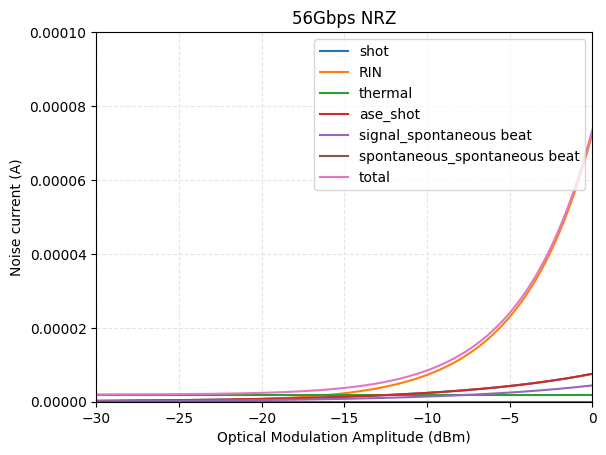

In [13]:

G = .1 #net gain through Booster 
F = 4

n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, G, F) #since laser_power is written as OMA (find noise corresponding to 1/0
n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, G, F)
rOMA_power_dBm = 10*np.log10(G*OMA_power/1e-3)
rOMA_current = max_current(G*OMA_power)
    #ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total']) 
    #error_rate.append(ber)

#plt.plot(laser_power_dBm, 10*np.log10(n1['thermal']**2+n2['thermal']**2), label="thermal")
plt.plot(rOMA_power_dBm, n1['shot']+n2['shot'], label="shot")
plt.plot(rOMA_power_dBm, n1['rin']+n2['rin'], label="RIN")
plt.plot(rOMA_power_dBm, n1['thermal']+n2['thermal'], label="thermal")
plt.plot(rOMA_power_dBm, n1['ase_shot']+n2['ase_shot'], label="ase_shot")
plt.plot(rOMA_power_dBm, n1['s_sp']+n2['s_sp'], label="signal_spontaneous beat")
plt.plot(rOMA_power_dBm, n1['sp_sp']+n2['sp_sp'], label="spontaneous_spontaneous beat")
plt.plot(rOMA_power_dBm, n1['total']+n2['total'], label="total")
#plt.plot(laser_power_dBm, Iavg, label="signal")
# plt.yticks(np.logspace(0, -16, 17))
plt.ylim(0, 0.0001)
plt.ylabel('Noise current (A)')
#plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
plt.xlabel('Optical Modulation Amplitude (dBm)')
plt.xlim(-30, 0)
plt.legend(loc='upper right')
plt.title("56Gbps NRZ")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()



In [4]:
# Estimate the minimum power 
cutoff_error = 1e-15

for i, bw in enumerate(bandwidth):
    idx = np.argwhere(error_rate[i] >= cutoff_error)[-1]
    l_power = OMA_power_dBm[idx][0]
    print(f"To achieve {cutoff_error} error, for {bw} GHz bandwidth, need {l_power:.2f} dBm")


IndexError: list index out of range

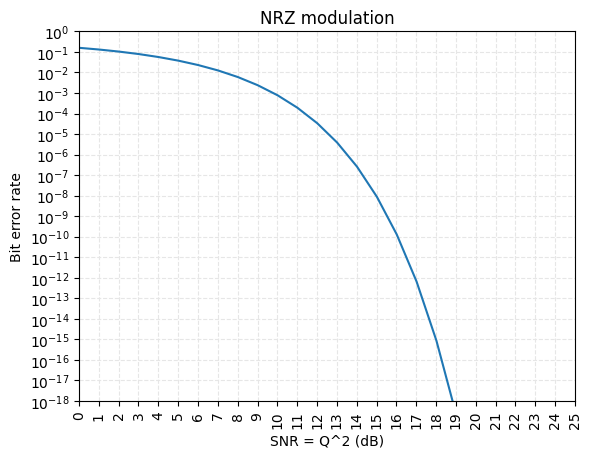

In [7]:
# Looking at BER vs. SNR

###definition of SNR = Q^2 to account for zero level noise
snr = np.linspace(0, 1001, 1001)  # in dB
error_rate = []
M =2
# note: snr = i**2 / noise**2
snr_ = np.power(10, snr/10)
Q = np.sqrt(snr_)
ber = pam_bit_error_rate(M, Q, 1.0)

#plt.figure(figsize=(4, 4), dpi=400)
plt.semilogy(snr, ber)
plt.yticks(np.logspace(0, -25, 26))
plt.ylim(1e-18, 1)
plt.ylabel('Bit error rate')
plt.xticks(np.arange(min(snr), 25 + 1, 1), rotation=90)
plt.xlabel('SNR = Q^2 (dB)')
plt.xlim(min(snr), 25)
# plt.legend(loc='upper right')
plt.title("NRZ modulation")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()

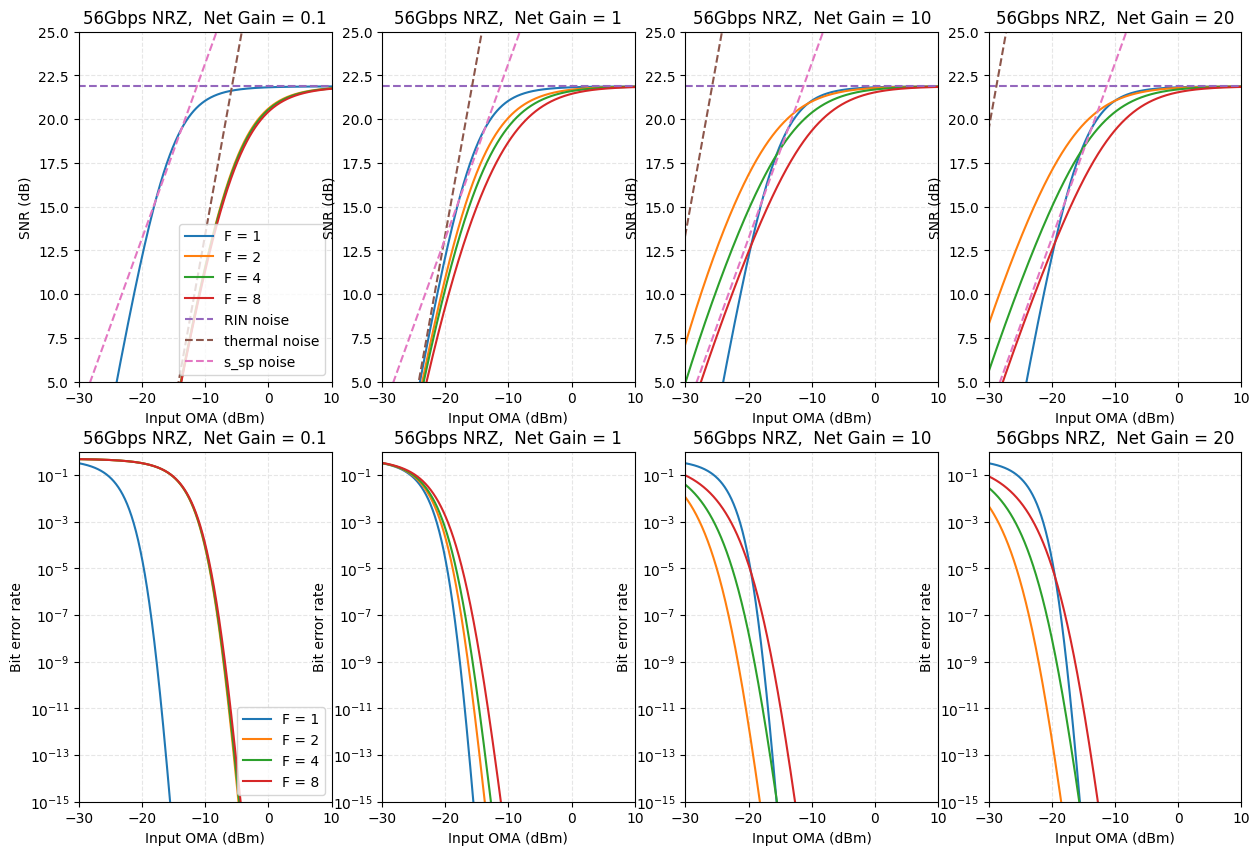

F=1 corresponds to no booster amplifier
RIN limited at SNR = 24dB
SNR = Q^2 = (I_1-I_0)^2/(n1+n0)^2
This definition of SNR is more closely aligned. SNR = (I1/n1)^2 is not applicable since that only applies when I0&n0 are negligible


In [10]:
# constants
h = 6.626e-34
wavelength = 1310e-9
c = 3e8
photon_energy = h*c/wavelength

#This is actually a sweep of the OMA
OMA_power_dBm = np.linspace(-40, 10, 1001)
OMA_power = 1e-3 * np.power(10, OMA_power_dBm/10, dtype=np.float64)

bandwidth = np.array([56]) # in GHz 56Gb/s corresponds to ~80Ghz approximate BW [Ghz] = 1.3*[Gb/s]
#convert Gb/s to Ghz --> Sync function
error_rate = []

#noise_figure = [0] #0 corresponds to no booster

lp1 = OMA_power*1.47 #These values roughly approximated from eye diagram for logical 1/0
lp0 = OMA_power*0.444

bw_e = 56
bw_o = 126

gain =[0.1, 1, 10, 20]
noise_figure = [1,2,4,8]

#plt.figure(figsize=(30, 10))
fig, axes = plt.subplots(2, len(gain), figsize = (15,10))
for indexG, G in enumerate(gain):
    for indexF, F in enumerate(noise_figure):
    
        if F==1:
            n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, 1, F) #since laser_power is written as OMA (find noise corresponding to 1/0)
            n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, 1, F)
            rOMA_power_dBm = 10*np.log10(1*OMA_power/1e-3)
            rOMA_current = max_current(1*OMA_power)
            ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total'])
        else:
            n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, G, F)
            n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, G, F)
            rOMA_power_dBm = 10*np.log10(G*OMA_power/1e-3)
            rOMA_current = max_current(G*OMA_power)
            ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total'])

        snr = 10*np.log10(rOMA_current**2/((n1['total']+n2['total'])**2))
        axes[0, indexG].plot(OMA_power_dBm, snr, label=f"F = {F}")
        axes[1, indexG].semilogy(OMA_power_dBm, ber, label=f"F = {F}")
    
    axes[0,indexG].plot(OMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['rin']+n2['rin'])**2)), linestyle = 'dashed', label="RIN noise")
    axes[0,indexG].plot(OMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['thermal']+n2['thermal'])**2)), linestyle = 'dashed', label="thermal noise")
    axes[0,indexG].plot(OMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['s_sp']+n2['s_sp'])**2)), linestyle = 'dashed', label="s_sp noise")
    #axes[0,indexG].plot(OMA_power_dBm, 10*np.log10(rOMA_current/(2*F*photon_energy*bw_e*1e9)), linestyle = 'dashed', label="s_sp calc")
    #plt.plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/(n1['shot']**2+n2['shot']**2)), linestyle = 'dashed', label="shot")

    axes[0,indexG].set_ylim(5, 25)
    axes[0,indexG].set_ylabel('SNR (dB)')
    #plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
    axes[0,indexG].set_xlabel('Input OMA (dBm)')
    axes[0,indexG].set_xlim(-30, 10)
    if indexG ==0:
        axes[0,indexG].legend(loc='lower right')
    axes[0,indexG].set_title("56Gbps NRZ,  " +f"Net Gain = {G}")
    axes[0,indexG].grid(True, which="both", ls="dashed", color='.9')

    axes[1,indexG].set_ylim(1e-15, 1)
    axes[1,indexG].set_ylabel('Bit error rate')
    #plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
    axes[1,indexG].set_xlabel('Input OMA (dBm)')
    axes[1,indexG].set_xlim((-30, 10))
    if indexG ==0:
        axes[1,indexG].legend(loc='lower right')
    axes[1,indexG].set_title("56Gbps NRZ,  " +f"Net Gain = {G}")
    axes[1,indexG].grid(True, which="both", ls="dashed", color='.9')


plt.show()
print("F=1 corresponds to no booster amplifier")
print("RIN limited at SNR = 24dB")
print("SNR = Q^2 = (I_1-I_0)^2/(n1+n0)^2")
print("This definition of SNR is more closely aligned. SNR = (I1/n1)^2 is not applicable since that only applies when I0&n0 are negligible")


###################


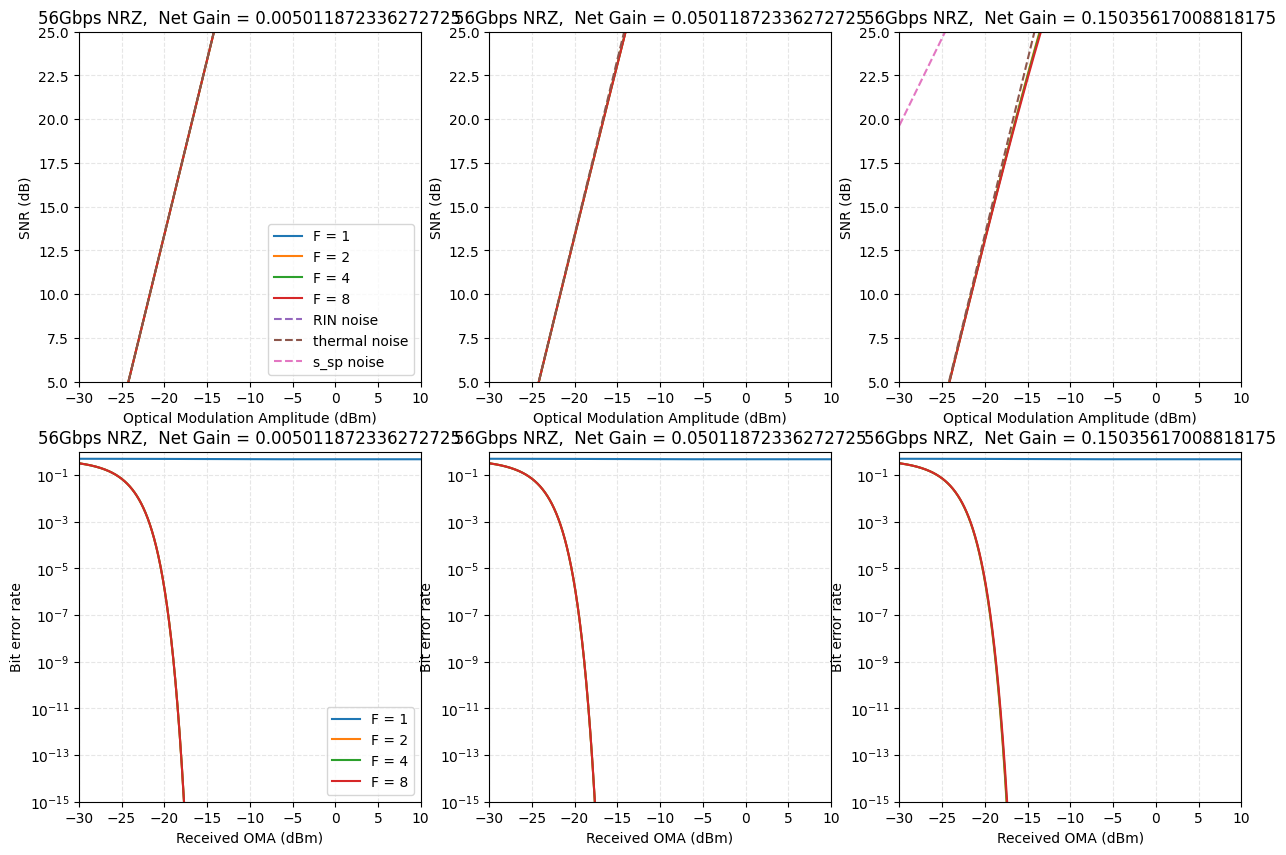

F=1 corresponds to no booster amplifier
RIN limited at SNR = 24dB
SNR = Q^2 = (I_1-I_0)^2/(n1+n0)^2
This definition of SNR is more closely aligned. SNR = (I1/n1)^2 is not applicable since that only applies when I0&n0 are negligible


In [11]:
#Lets do this another way, which does the netgain

inOMA_power_dBm = np.linspace(-30, 20, 1001)
inOMA_power = 1e-3 * np.power(10, inOMA_power_dBm/10, dtype=np.float64)

bandwidth = np.array([56]) # in GHz 56Gb/s corresponds to ~80Ghz approximate BW [Ghz] = 1.3*[Gb/s]
#convert Gb/s to Ghz --> Sync function
error_rate = []

#noise_figure = [0] #0 corresponds to no booster

lp1 = inOMA_power*1.47 #These values roughly approximated from eye diagram for logical 1/0
lp0 = inOMA_power*0.444

bw_e = 56
bw_o = 126

loss_dB = -23
loss = 10**(loss_dB/10)
gain_soa =[1.0, 10.0, 30.0]
gain = [g * loss for g in gain_soa]
noise_figure = [1,2,4,8]

#plt.figure(figsize=(30, 10))
fig, axes = plt.subplots(2, 3, figsize = (15,10))
for indexG, G in enumerate(gain):
    for indexF, F in enumerate(noise_figure):
    
        if F==1:
            n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, 1, F) #since laser_power is written as OMA (find noise corresponding to 1/0)
            n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, 1, F)
            rOMA_power_dBm = 10*np.log10(inOMA_power/1e-3)
            rOMA_current = max_current(loss*inOMA_power)
            ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total'])
        else:
            n1 = calculate_noise(bw_e*1e9, bw_o*1e9, lp1, 0, G, F)
            n2 = calculate_noise(bw_e*1e9, bw_o*1e9, lp0, 0, G, F)
            rOMA_power_dBm = 10*np.log10(inOMA_power/1e-3)
            rOMA_current = max_current(inOMA_power)
            ber = nrz_bit_error_rate(rOMA_current, n1['total']+n2['total'])

        snr = 10*np.log10(rOMA_current**2/((n1['total']+n2['total'])**2))
        axes[0, indexG].plot(rOMA_power_dBm, snr, label=f"F = {F}")
        axes[1, indexG].semilogy(rOMA_power_dBm, ber, label=f"F = {F}")
    
    axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['rin']+n2['rin'])**2)), linestyle = 'dashed', label="RIN noise")
    axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['thermal']+n2['thermal'])**2)), linestyle = 'dashed', label="thermal noise")
    axes[0,indexG].plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/((n1['s_sp']+n2['s_sp'])**2)), linestyle = 'dashed', label="s_sp noise")
    #plt.plot(rOMA_power_dBm, 10*np.log10(rOMA_current**2/(n1['shot']**2+n2['shot']**2)), linestyle = 'dashed', label="shot")

    axes[0,indexG].set_ylim(5, 25)
    axes[0,indexG].set_ylabel('SNR (dB)')
    #plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
    axes[0,indexG].set_xlabel('Optical Modulation Amplitude (dBm)')
    axes[0,indexG].set_xlim(-30, 10)
    if indexG ==0:
        axes[0,indexG].legend(loc='lower right')
    axes[0,indexG].set_title("56Gbps NRZ,  " +f"Net Gain = {G}")
    axes[0,indexG].grid(True, which="both", ls="dashed", color='.9')

    axes[1,indexG].set_ylim(1e-15, 1)
    axes[1,indexG].set_ylabel('Bit error rate')
    #plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
    axes[1,indexG].set_xlabel('Received OMA (dBm)')
    axes[1,indexG].set_xlim((-30, 10))
    if indexG ==0:
        axes[1,indexG].legend(loc='lower right')
    axes[1,indexG].set_title("56Gbps NRZ,  " +f"Net Gain = {G}")
    axes[1,indexG].grid(True, which="both", ls="dashed", color='.9')


plt.show()
print("F=1 corresponds to no booster amplifier")
print("RIN limited at SNR = 24dB")
print("SNR = Q^2 = (I_1-I_0)^2/(n1+n0)^2")
print("This definition of SNR is more closely aligned. SNR = (I1/n1)^2 is not applicable since that only applies when I0&n0 are negligible")


###################


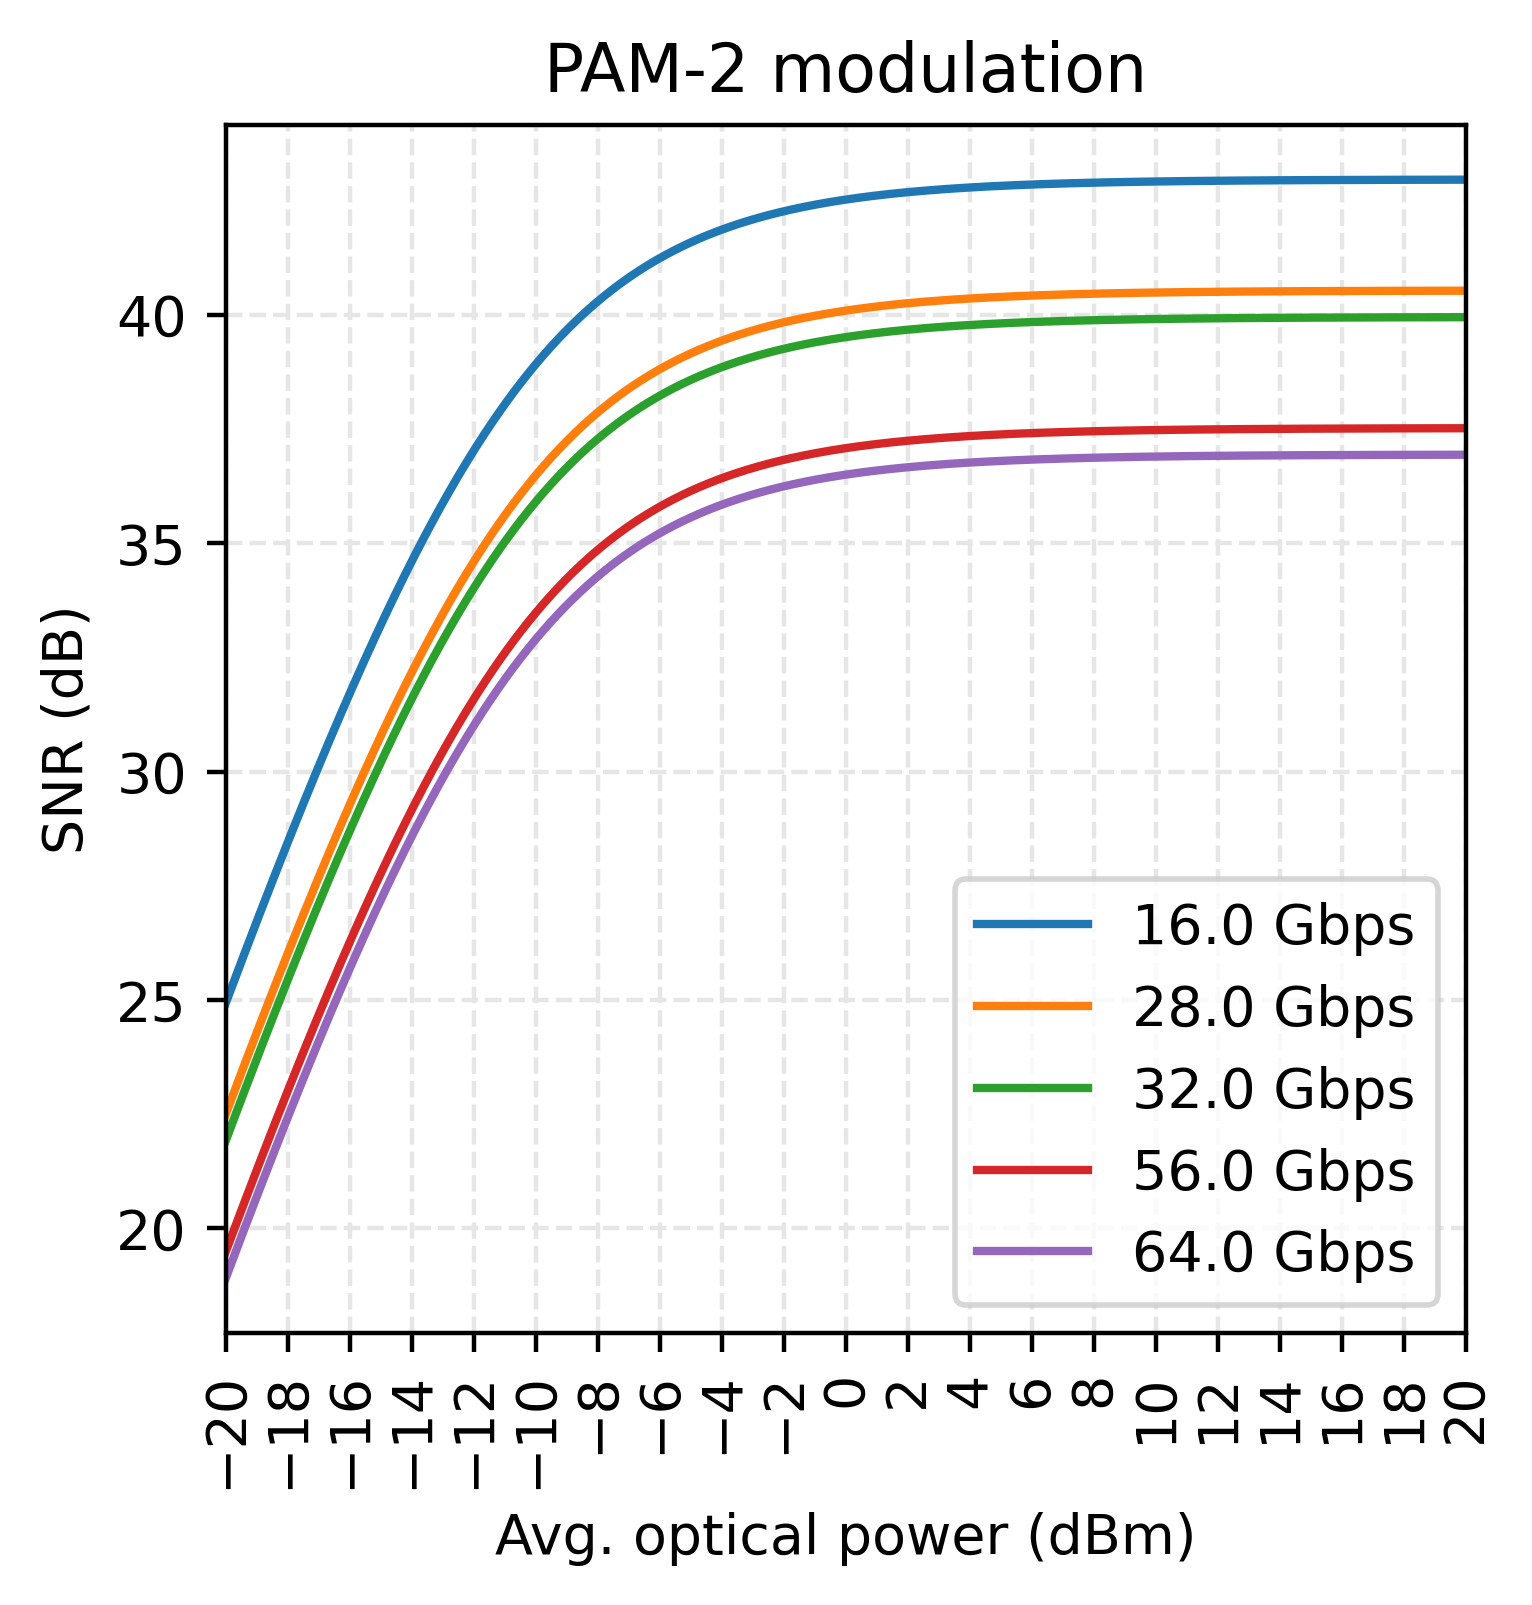

In [58]:
laser_power_dBm = np.linspace(-20, 20, 1001)
laser_power = 1e-3 * np.power(10, laser_power_dBm / 10, dtype=np.float64)

M = 2
bandwidth = np.array([16, 28, 32, 56, 64])  # in GHz

snr = []

for bw in bandwidth:
    noise = calculate_noise(M, bw * 1e9, laser_power)
    I = max_current(laser_power)
    snr.append(I**2/noise**2)

snr = np.array(snr)
snr = 10*np.log10(snr)  # in dB
labels = [f"{bw*np.log2(M)} Gbps" for bw in bandwidth]

plt.figure(figsize=(4, 4), dpi=400)
plt.plot(laser_power_dBm, snr.T, label=labels)
# plt.yticks(np.arange(15, 50, 1))
# plt.ylim(15, 21)
plt.ylabel('SNR (dB)')
plt.xticks(np.arange(min(laser_power_dBm),
                     max(laser_power_dBm) + 1, 2),
           rotation=90)
plt.xlabel('Avg. optical power (dBm)')
plt.xlim(min(laser_power_dBm), max(laser_power_dBm))
plt.legend(loc='lower right')
plt.title(f"PAM-{M} modulation")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()